<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data,-policy-and-model-initialization" data-toc-modified-id="Data,-policy-and-model-initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data, policy and model initialization</a></span><ul class="toc-item"><li><span><a href="#Load-contact-data" data-toc-modified-id="Load-contact-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load contact data</a></span></li><li><span><a href="#Load-publically-available-data-from-Sciensano" data-toc-modified-id="Load-publically-available-data-from-Sciensano-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load publically available data from Sciensano</a></span></li><li><span><a href="#Load-posterior-parameter-distributions-of-calibrated-parameters" data-toc-modified-id="Load-posterior-parameter-distributions-of-calibrated-parameters-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load posterior parameter distributions of calibrated parameters</a></span></li><li><span><a href="#Settings" data-toc-modified-id="Settings-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Settings</a></span></li></ul></li><li><span><a href="#Helpfunctions-vaccination" data-toc-modified-id="Helpfunctions-vaccination-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Helpfunctions vaccination</a></span></li><li><span><a href="#Vaccination-functions" data-toc-modified-id="Vaccination-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Vaccination functions</a></span><ul class="toc-item"><li><span><a href="#Equal-divide-after-elderly" data-toc-modified-id="Equal-divide-after-elderly-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Equal divide after elderly</a></span></li><li><span><a href="#Prioritise-after-elderly" data-toc-modified-id="Prioritise-after-elderly-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Prioritise after elderly</a></span></li></ul></li><li><span><a href="#Functions" data-toc-modified-id="Functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Time-dep-functions" data-toc-modified-id="Time-dep-functions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Time-dep functions</a></span></li><li><span><a href="#Test-model" data-toc-modified-id="Test-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test model</a></span></li><li><span><a href="#Test-vacc-strategy" data-toc-modified-id="Test-vacc-strategy-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Test vacc strategy</a></span></li><li><span><a href="#Test-UK-injection" data-toc-modified-id="Test-UK-injection-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Test UK injection</a></span></li><li><span><a href="#Verify-vaccination-function" data-toc-modified-id="Verify-vaccination-function-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Verify vaccination function</a></span><ul class="toc-item"><li><span><a href="#Overall" data-toc-modified-id="Overall-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Overall</a></span></li><li><span><a href="#Per-age-group" data-toc-modified-id="Per-age-group-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Per age group</a></span></li></ul></li><li><span><a href="#Test-spatial-model" data-toc-modified-id="Test-spatial-model-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Test spatial model</a></span></li><li><span><a href="#Scenarios" data-toc-modified-id="Scenarios-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Scenarios</a></span><ul class="toc-item"><li><span><a href="#Run-and-save-all-scenarios" data-toc-modified-id="Run-and-save-all-scenarios-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Run and save all scenarios</a></span></li><li><span><a href="#Scenarios-S1-(current-behaviour)" data-toc-modified-id="Scenarios-S1-(current-behaviour)-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Scenarios S1 (current behaviour)</a></span><ul class="toc-item"><li><span><a href="#S1a---K-=-1.3" data-toc-modified-id="S1a---K-=-1.3-11.2.1"><span class="toc-item-num">11.2.1&nbsp;&nbsp;</span>S1a - K = 1.3</a></span></li><li><span><a href="#S1b---K-=-1.5" data-toc-modified-id="S1b---K-=-1.5-11.2.2"><span class="toc-item-num">11.2.2&nbsp;&nbsp;</span>S1b - K = 1.5</a></span></li><li><span><a href="#S1c---K-=-1.7" data-toc-modified-id="S1c---K-=-1.7-11.2.3"><span class="toc-item-num">11.2.3&nbsp;&nbsp;</span>S1c - K = 1.7</a></span></li></ul></li><li><span><a href="#Scenarios-S2-(september-behaviour-March-1)" data-toc-modified-id="Scenarios-S2-(september-behaviour-March-1)-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>Scenarios S2 (september behaviour March 1)</a></span><ul class="toc-item"><li><span><a href="#S2a---K-=-1.3" data-toc-modified-id="S2a---K-=-1.3-11.3.1"><span class="toc-item-num">11.3.1&nbsp;&nbsp;</span>S2a - K = 1.3</a></span></li><li><span><a href="#S2b---K-=-1.5" data-toc-modified-id="S2b---K-=-1.5-11.3.2"><span class="toc-item-num">11.3.2&nbsp;&nbsp;</span>S2b - K = 1.5</a></span></li></ul></li><li><span><a href="#Scenarios-SNV1-(vaccination-effect)" data-toc-modified-id="Scenarios-SNV1-(vaccination-effect)-11.4"><span class="toc-item-num">11.4&nbsp;&nbsp;</span>Scenarios SNV1 (vaccination effect)</a></span><ul class="toc-item"><li><span><a href="#S3a-(S2b-without-vaccination)" data-toc-modified-id="S3a-(S2b-without-vaccination)-11.4.1"><span class="toc-item-num">11.4.1&nbsp;&nbsp;</span>S3a (S2b without vaccination)</a></span></li><li><span><a href="#S4a-(S1b-without-vaccination)" data-toc-modified-id="S4a-(S1b-without-vaccination)-11.4.2"><span class="toc-item-num">11.4.2&nbsp;&nbsp;</span>S4a (S1b without vaccination)</a></span></li></ul></li></ul></li><li><span><a href="#Visualise" data-toc-modified-id="Visualise-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Visualise</a></span><ul class="toc-item"><li><span><a href="#S1-and-S2" data-toc-modified-id="S1-and-S2-12.1"><span class="toc-item-num">12.1&nbsp;&nbsp;</span>S1 and S2</a></span></li><li><span><a href="#Vaccination-effect" data-toc-modified-id="Vaccination-effect-12.2"><span class="toc-item-num">12.2&nbsp;&nbsp;</span>Vaccination effect</a></span></li></ul></li><li><span><a href="#Alternative-scenarios-A1" data-toc-modified-id="Alternative-scenarios-A1-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Alternative scenarios A1</a></span><ul class="toc-item"><li><span><a href="#A1a---vacc---old-strain" data-toc-modified-id="A1a---vacc---old-strain-13.1"><span class="toc-item-num">13.1&nbsp;&nbsp;</span>A1a - vacc - old strain</a></span></li><li><span><a href="#A1b---no-vacc---new-strain" data-toc-modified-id="A1b---no-vacc---new-strain-13.2"><span class="toc-item-num">13.2&nbsp;&nbsp;</span>A1b - no vacc - new strain</a></span></li><li><span><a href="#A1c---vaccination---old-strain" data-toc-modified-id="A1c---vaccination---old-strain-13.3"><span class="toc-item-num">13.3&nbsp;&nbsp;</span>A1c - vaccination - old strain</a></span></li><li><span><a href="#A1d---vaccination---new-strain" data-toc-modified-id="A1d---vaccination---new-strain-13.4"><span class="toc-item-num">13.4&nbsp;&nbsp;</span>A1d - vaccination - new strain</a></span></li><li><span><a href="#Visualise" data-toc-modified-id="Visualise-13.5"><span class="toc-item-num">13.5&nbsp;&nbsp;</span>Visualise</a></span></li></ul></li><li><span><a href="#Alternative-scenarios-A2" data-toc-modified-id="Alternative-scenarios-A2-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Alternative scenarios A2</a></span><ul class="toc-item"><li><span><a href="#A2a---no-vacc---old-strain" data-toc-modified-id="A2a---no-vacc---old-strain-14.1"><span class="toc-item-num">14.1&nbsp;&nbsp;</span>A2a - no vacc - old strain</a></span></li><li><span><a href="#A2b---no-vacc---new-strain" data-toc-modified-id="A2b---no-vacc---new-strain-14.2"><span class="toc-item-num">14.2&nbsp;&nbsp;</span>A2b - no vacc - new strain</a></span></li><li><span><a href="#A2c---vaccination---old-strain" data-toc-modified-id="A2c---vaccination---old-strain-14.3"><span class="toc-item-num">14.3&nbsp;&nbsp;</span>A2c - vaccination - old strain</a></span></li><li><span><a href="#A2d---vaccination---new-strain" data-toc-modified-id="A2d---vaccination---new-strain-14.4"><span class="toc-item-num">14.4&nbsp;&nbsp;</span>A2d - vaccination - new strain</a></span></li><li><span><a href="#Visualise" data-toc-modified-id="Visualise-14.5"><span class="toc-item-num">14.5&nbsp;&nbsp;</span>Visualise</a></span></li></ul></li><li><span><a href="#Save-data" data-toc-modified-id="Save-data-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Save data</a></span></li><li><span><a href="#Plot-saved-data" data-toc-modified-id="Plot-saved-data-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Plot saved data</a></span></li></ul></div>


*Authored by J. Vergeynst*

Copyright (c) 2021 by J. Vergeynst, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import scipy
import json
import random
from math import floor, ceil

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.models.time_dependant_parameter_fncs import ramp_fun, google_lockdown
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator
from covid19model.visualization.optimization import plot_fit, traceplot

plt.rcParams.update({'font.size': 12, 'axes.grid':True, 'grid.linewidth':0.3})
pd.plotting.register_matplotlib_converters()

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [ ]:
%load_ext snakeviz

In [ ]:
plt.rcParams.update({
    "lines.linewidth" : 3,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "ytick.major.left": True,
    "axes.grid": True
})

# Data, policy and model initialization

## Load contact data

In [2]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='all')
# Define the number of age categories
levels = initN.size

initN, Nc_home_15, Nc_work_15, Nc_schools_15, Nc_transport_15, Nc_leisure_15, Nc_others_15, Nc_total_15 = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_15_min')
initN, Nc_home_1hr, Nc_work_1hr, Nc_schools_1hr, Nc_transport_1hr, Nc_leisure_1hr, Nc_others_1hr, Nc_total_1hr = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_one_hour')

In [3]:
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}
Nc_15min = {'total': Nc_total_15, 'home': Nc_home_15, 'work': Nc_work_15, 'schools': Nc_schools_15, 'transport': Nc_transport_15, 'leisure': Nc_leisure_15, 'others': Nc_others_15}
Nc_1hr = {'total': Nc_total_1hr, 'home': Nc_home_1hr, 'work': Nc_work_1hr, 'schools': Nc_schools_1hr, 'transport': Nc_transport_1hr, 'leisure': Nc_leisure_1hr, 'others': Nc_others_1hr}

## Load publically available data from Sciensano

In [4]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano['D_cum'] = df_sciensano.D_tot.cumsum()

In [5]:
df_google = mobility.get_google_mobility_data(update=False, plot=False)

## Load posterior parameter distributions of calibrated parameters

In [242]:
# Load samples dictionaries
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_4_prev_full_2021-01-30_WAVE2_GOOGLE.json', 'r') as fp:
    samples_dict = json.load(fp)

with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/initial_states_2020-09-01.json', 'r') as fp:
    initial_states_sept = json.load(fp) 
    
# Set initial states of VE (vaccine elegible)
initial_states_sept['VE'] = (np.array(initial_states_sept['S'])+
                             np.array(initial_states_sept['R'])+
                             np.array(initial_states_sept['E'])+
                             np.array(initial_states_sept['I'])+
                             np.array(initial_states_sept['A'])).squeeze()

In [ ]:
# fig,ax = plt.subplots()
# pd.Series(samples_dict['beta']).hist()
# pd.Series(samples_dict['tau']).hist()

## Settings

In [7]:
UL = 0.975
LL = 0.025

In [8]:
start_calibration = '2021-01-01'
end_sim = '2021-09-01'

Alle vaccins twee dosissen nodig (Pfizer, Moderna, AstraZeneca, Curevac) behalve Johnson&Johnson (pas vanaf mei)

In [9]:
# doses per day (Regeringscommissariaat Corona, published by De Tijd)
d = {}
d['jan'] = 31765
d['feb'] = 45897
d['mar-apr'] = 128499
d['may-aug'] = 78358

# proportion of age group living in nursing homes
# for simplicity we will use the data for respectively age groups 60+, 70+ and 80+
NH = {}
NH['65+'] = 0.007
NH['75+'] = (0.05+0.029)/2
NH['85+'] = (0.137+0.267)/2


# Helpfunctions vaccination

In [10]:
# def sigmoid(x,mi, mx): 
#     return mi + (mx-mi)*(lambda t: (1+200**(-t+0.5))**(-1) )( (x-mi)/(mx-mi) )

In [11]:
def smoothclamp(x, mi, mx): 
    return mi + (mx-mi)*(lambda t: np.where(t < 0 , 0, np.where( t <= 1 , 3*t**2-2*t**3, 1 ) ) )( (x-mi)/(mx-mi) )

In [ ]:
# dose=1000
# fig, ax = plt.subplots(1, 1)
# x = np.linspace(0, dose)
# ax.plot(x, np.clip(x, 0, dose),'k-', lw=2, alpha=0.8, label='clamp')
# ax.plot(x, smoothclamp(x, 0, dose),'g-', lw=3, alpha=0.5, label='smoothclamp')
# ax.plot(x, sigmoid(x, 0, dose),'b-', lw=3, alpha=0.5, label='sigmoid')
# plt.legend(loc='upper left')
# plt.show()

In [12]:
def smooth_dose(dose, sense, start_dose=0, end_dose=0, N=1000):
    if sense == 'up':
        x = np.linspace(start_dose, dose, num=N)
        return smoothclamp(x, start_dose, dose)
    elif sense == 'down':
        x = np.linspace(dose, end_dose, num=N)
        return smoothclamp(x, dose, end_dose)
    else:
        raise ValueError(
                "sense must be 'up' or 'down' "
            )

In [14]:
def smooth_dose_ts(daily_dose, start_t, end_t, spread, start_dose=0, end_dose=0, N=1000):
    """
    max_to_vacc : max number to vaccinate
    daily_dose : daily number of vaccinations
    spread : number of days at start and end to spread out step function
    N : resolution of the smoothed step function
    start_dose : level to start smoothing from (0 or previous daily dose)
    
    """
    constant_period = np.linspace(start_t+spread, end_t-spread, num=ceil(end_t))
    
    ts = np.concatenate((np.linspace(start_t, start_t+spread, num=N), 
                         constant_period,
                         np.linspace(end_t-spread, end_t, num=N)  
                         )) 
    
    doses = np.concatenate((smooth_dose(daily_dose, 'up', start_dose=start_dose, N=N),
                    np.repeat(np.array(daily_dose), len(constant_period)),
                    smooth_dose(daily_dose, 'down', end_dose=end_dose, N=N)))
    return ts, doses

In [44]:
def smooth_dose_ts_open_end(daily_dose, start_t, spread, start_dose=0, N_days=100, N=1000):
    """
    max_to_vacc : max number to vaccinate
    daily_dose : daily number of vaccinations
    N_days : number of days to spread out open end
    spread : number of days at start/end to spread out step function
    N : resolution of the smoothed step function
    
    """
    constant_period = np.linspace(start_t+spread, 100, num=N_days)
    
    ts = np.concatenate((np.linspace(start_t, start_t+spread, num=N), 
                         constant_period
                         )) 
    
    doses = np.concatenate((smooth_dose(daily_dose, 'up', start_dose=start_dose, N=N),
                            np.repeat(np.array(daily_dose), len(constant_period))
                            ))
    return ts, doses

In [16]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [149]:
def calc_N_vacc(N_vacc, age, prev_age, VE_states, dose, leftover, flag):
    if (VE_states[:,[age]] > leftover) and flag:
        dose = dose-N_vacc[:,[prev_age]]
        N_vacc[:,[age]] = dose 
        flag=False
        if (VE_states[:,[age]]-leftover) <= dose:
            N_vacc[:,[age]] = VE_states[:,[age]]-leftover 
            flag=True
    return N_vacc[:,[age]], flag

In [ ]:
# daily_dose = d['jan']/2
# end_t = NH_8_to_vacc/daily_dose
# end_t2 = end_t+NH_7_to_vacc/daily_dose
# end_t3 = end_t2 + NH_6_to_vacc/daily_dose
# end = 30

In [ ]:
# ts1, doses1 = smooth_dose_ts(daily_dose, 0, end_t, spread=2)
# ts2, doses2 = smooth_dose_ts(daily_dose, end_t, end_t2, spread=1)
# ts3, doses3 = smooth_dose_ts(daily_dose, end_t2, end_t3, spread=0.3)
# ts4, doses4 = smooth_dose_ts(daily_dose, end_t3, end, spread=2, start_dose=8000, end_dose=12000)

# fig,ax = plt.subplots()
# ax.plot(ts1,doses1)
# ax.plot(ts2,doses2)
# ax.plot(ts3,doses3)
# ax.plot(ts4,doses4)

In [26]:
# ts_open, doses_open = smooth_dose_ts_open_end(daily_dose=1000, start_t=0, spread=1, N=1000)
# fig,ax = plt.subplots()
# ax.plot(ts_open,doses_open)

# Vaccination functions

In [17]:
NH_8_to_vacc = NH['85+']*initial_states_sept['VE'][8]
NH_7_to_vacc = NH['75+']*initial_states_sept['VE'][7]
NH_6_to_vacc = NH['65+']*initial_states_sept['VE'][6]

In [18]:
# Which age group has most contacts with all other age groups?
contact_sums = Nc_total.sum(axis=1)
contact_sums = pd.DataFrame({'contacts':Nc_total.sum(axis=1), 'age_group':[0,1,2,3,4,5,6,7,8]})
list(contact_sums.sort_values('contacts', ascending=False).age_group)

[3, 4, 1, 2, 5, 0, 6, 7, 8]

## Equal divide after elderly

In [251]:
def vacc_strategy(t, states, param, d, NH, order, elder):
    """
    time-dependent function for vaccination strategy
    
    states : dictionary
        model states, VE = vaccine eligible states = S+R+E+I+A
    d : dictionary
        daily number of doses for that month
        daily vaccinated persons on immunity date = daily dose on vaccination date / 2
    NH : dictionary
        proportion of residents in nursing homes per age group
    
    """
    
    leftover = 100
    
    VE_states = states['VE'].copy()
    
    if VE_states.ndim == 1:
        VE_states = VE_states[np.newaxis]

    N_vacc = np.zeros(VE_states.shape)

    delay = pd.Timedelta('30D')
    
    t1 = pd.Timestamp('2021-01-01') + delay
    t2 = pd.Timestamp('2021-02-01') + delay
    t3 = pd.Timestamp('2021-03-01') + delay
    t4 = pd.Timestamp('2021-05-01') + delay
    daily_dose_jan = d['jan']/2
    daily_dose_feb = d['feb']/2
    daily_dose_ma_ap = d['mar-apr']/2
    daily_dose_may_aug = d['may-aug']/2
    
    if t < t1:
        N_vacc = N_vacc
    
    elif t1 <= t < t2: # January : nursing homes + part of care personnel
        t_num = (t-t1)/pd.Timedelta('1D')
        end_phase1 = NH_8_to_vacc/daily_dose_jan
        end_phase2 = end_phase1 + NH_7_to_vacc/daily_dose_jan
        end_phase3 = end_phase2 + NH_6_to_vacc/daily_dose_jan
        end_t2 = (t2-t1)/pd.Timedelta('1D')
        if t_num < end_phase1:
            ts, doses = smooth_dose_ts(daily_dose_jan, 0, end_phase1, spread=2)
            N_vacc[:,[8]] = doses[find_nearest_idx(ts, t_num)]
        elif t_num < end_phase2:
            ts, doses = smooth_dose_ts(daily_dose_jan, end_phase1, end_phase2, spread=1)
            N_vacc[:,[7]] = doses[find_nearest_idx(ts, t_num)]
        elif t_num < end_phase3:
            ts, doses = smooth_dose_ts(daily_dose_jan, end_phase2, end_phase3, spread=0.3)
            N_vacc[:,[6]] = doses[find_nearest_idx(ts, t_num)]
        else: 
            ts, doses = smooth_dose_ts(daily_dose_jan, end_phase3, end_t2, spread=4, end_dose=daily_dose_feb)
            N_vacc[:,[5,4,3,2]] = doses[find_nearest_idx(ts, t_num)]/4

    elif t2 <= t < t3: # February : care personnel
        t_num = (t-t2)/pd.Timedelta('1D')
        end_t3 = (t3-t2)/pd.Timedelta('1D')
        ts, doses = smooth_dose_ts(daily_dose_feb, 0, end_t3, spread=4, start_dose=daily_dose_jan)
        N_vacc[:,[5,4,3,2]] = doses[find_nearest_idx(ts, t_num)]/4
        
    elif t3 <= t < t4: # March-April : 65+ and risk patients
        t_num = (t-t3)/pd.Timedelta('1D')
        if VE_states[:,[elder[0]]] > leftover:
            ts, doses = smooth_dose_ts_open_end(daily_dose_ma_ap, 0, spread=2)
            N_vacc[:,[elder[0]]] = doses[find_nearest_idx(ts, t_num)]
            ## One daily dose before all 80+ are vaccinated, start building down
            if (VE_states[:,[elder[0]]]-leftover) <= daily_dose_ma_ap:
                N_vacc[:,[elder[0]]] = VE_states[:,[elder[0]]]-leftover
                
                flag = True
                N_vacc[:,[elder[1]]],flag = calc_N_vacc(N_vacc, elder[1], elder[0], VE_states, daily_dose_ma_ap, leftover,flag)
                N_vacc[:,[elder[2]]],flag = calc_N_vacc(N_vacc, elder[2], elder[1], VE_states, daily_dose_ma_ap, leftover,flag)
                if flag==True and len(np.unique(elder))==3:
                    N_vacc[:,[5,4,3,2]] = (daily_dose_ma_ap - N_vacc[:,[elder[2]]])/4
                if flag==True and len(np.unique(elder))==2:
                    N_vacc[:,[6,5,4,3,2]] = (daily_dose_ma_ap - N_vacc[:,[elder[2]]])/5
                                

    else: # May-August : all 18+ 
        t_num = (t-t4)/pd.Timedelta('1D')
        ts, doses = smooth_dose_ts_open_end(daily_dose_may_aug, 0, spread=3)#, start_dose=daily_dose_ma_ap/4
        if len(np.unique(elder))==3:
            N_vacc[:,[5,4,3,2]] = doses[find_nearest_idx(ts, t_num)]/4
        elif len(np.unique(elder))==2:
            N_vacc[:,[6,5,4,3,2]] = doses[find_nearest_idx(ts, t_num)]/5
    return N_vacc.squeeze()

## Prioritise after elderly

In [161]:
def vacc_strategy_priors(t, states, param, d, NH, order, elder):
    """
    time-dependent function for vaccination strategy
    
    states : dictionary
        model states, VE = vaccine eligible states = S+R+E+I+A
    d : dictionary
        daily number of doses for that month
        daily vaccinated persons on immunity date = daily dose on vaccination date / 2
    NH : dictionary
        proportion of residents in nursing homes per age group
    order : list
        order of age categories to be vaccinated after the elderly
    elder : list
        order of elderly age categories ([8,7,6] or if 60+ not prioritised [8,7,7])
    
    """
    if len(order)!=7:
        raise ValueError(
                "order must have length 7"
            )
    if len(elder)!=3:
        raise ValueError(
                "elder must have length 3"
            )        
    
    leftover = 100
    
    VE_states = states['VE'].copy()
    if VE_states.ndim == 1:
        VE_states = VE_states[np.newaxis]

    N_vacc = np.zeros(VE_states.shape)

    delay = pd.Timedelta('30D')
    
    t1 = pd.Timestamp('2021-01-01') + delay
    t2 = pd.Timestamp('2021-02-01') + delay
    t3 = pd.Timestamp('2021-03-01') + delay
    t4 = pd.Timestamp('2021-05-01') + delay
    daily_dose_jan = d['jan']/2
    daily_dose_feb = d['feb']/2
    daily_dose_ma_ap = d['mar-apr']/2
    daily_dose_may_aug = d['may-aug']/2
    
    if t < t1:
        N_vacc = N_vacc
    
    elif t1 <= t < t2: # January : nursing homes + part of care personnel
        t_num = (t-t1)/pd.Timedelta('1D')
        end_phase1 = NH_8_to_vacc/daily_dose_jan
        end_phase2 = end_phase1 + NH_7_to_vacc/daily_dose_jan
        end_phase3 = end_phase2 + NH_6_to_vacc/daily_dose_jan
        end_t2 = (t2-t1)/pd.Timedelta('1D')
        if t_num < end_phase1:
            ts, doses = smooth_dose_ts(daily_dose_jan, 0, end_phase1, spread=2)
            N_vacc[:,[8]] = doses[find_nearest_idx(ts, t_num)]
        elif t_num < end_phase2:
            ts, doses = smooth_dose_ts(daily_dose_jan, end_phase1, end_phase2, spread=1)
            N_vacc[:,[7]] = doses[find_nearest_idx(ts, t_num)]
        elif t_num < end_phase3:
            ts, doses = smooth_dose_ts(daily_dose_jan, end_phase2, end_phase3, spread=0.3)
            N_vacc[:,[6]] = doses[find_nearest_idx(ts, t_num)]
        else: 
            ts, doses = smooth_dose_ts(daily_dose_jan, end_phase3, end_t2, spread=4, end_dose=daily_dose_feb)
            N_vacc[:,[5,4,3,2]] = doses[find_nearest_idx(ts, t_num)]/4

    elif t2 <= t < t3: # February : care personnel
        t_num = (t-t2)/pd.Timedelta('1D')
        end_t3 = (t3-t2)/pd.Timedelta('1D')
        ts, doses = smooth_dose_ts(daily_dose_feb, 0, end_t3, spread=4, start_dose=daily_dose_jan)
        N_vacc[:,[5,4,3,2]] = doses[find_nearest_idx(ts, t_num)]/4
         
    elif t3 <= t < t4: # March-April : 65+ and risk patients
        t_num = (t-t3)/pd.Timedelta('1D')
        if VE_states[:,[elder[0]]] > leftover:
            ts, doses = smooth_dose_ts_open_end(daily_dose_ma_ap, 0, spread=2)
            N_vacc[:,[elder[0]]] = doses[find_nearest_idx(ts, t_num)]
            ## One daily dose before all 80+ are vaccinated, start building down
            if (VE_states[:,[elder[0]]]-leftover) <= daily_dose_ma_ap:
                N_vacc[:,[elder[0]]] = VE_states[:,[elder[0]]]-leftover
                
                flag = True
                N_vacc[:,[elder[1]]],flag = calc_N_vacc(N_vacc, elder[1], elder[0], VE_states, daily_dose_ma_ap, leftover,flag)
                N_vacc[:,[elder[2]]],flag = calc_N_vacc(N_vacc, elder[2], elder[1], VE_states, daily_dose_ma_ap, leftover,flag)
                N_vacc[:,[order[0]]],flag = calc_N_vacc(N_vacc, order[0], elder[2], VE_states, daily_dose_ma_ap, leftover,flag)
                N_vacc[:,[order[1]]],flag = calc_N_vacc(N_vacc, order[1], order[0], VE_states, daily_dose_ma_ap, leftover,flag)
                N_vacc[:,[order[2]]],flag = calc_N_vacc(N_vacc, order[2], order[1], VE_states, daily_dose_ma_ap, leftover,flag)          
                
    else: # May-August : all 18+
        
        t_num = (t-t4)/pd.Timedelta('1D')
        if VE_states[:,[order[0]]] > leftover:
            ts, doses = smooth_dose_ts_open_end(daily_dose_may_aug, 0, spread=2)
            N_vacc[:,[order[0]]] = doses[find_nearest_idx(ts, t_num)]
            ## One daily dose before all 80+ are vaccinated, start building down
            if (VE_states[:,[order[0]]]-leftover) <= daily_dose_may_aug:
                N_vacc[:,[order[0]]] = VE_states[:,[order[0]]]-leftover  
                
                flag = True
                N_vacc[:,[order[1]]],flag = calc_N_vacc(N_vacc, order[1], order[0], VE_states, daily_dose_may_aug, leftover,flag)
                N_vacc[:,[order[2]]],flag = calc_N_vacc(N_vacc, order[2], order[1], VE_states, daily_dose_may_aug, leftover,flag)
                N_vacc[:,[order[3]]],flag = calc_N_vacc(N_vacc, order[3], order[2], VE_states, daily_dose_may_aug, leftover,flag)
                N_vacc[:,[order[4]]],flag = calc_N_vacc(N_vacc, order[4], order[3], VE_states, daily_dose_may_aug, leftover,flag)
                N_vacc[:,[order[5]]],flag = calc_N_vacc(N_vacc, order[5], order[4], VE_states, daily_dose_may_aug, leftover,flag)
                N_vacc[:,[order[6]]],flag = calc_N_vacc(N_vacc, order[6], order[5], VE_states, daily_dose_may_aug, leftover,flag)

                
    return N_vacc.squeeze()

# Functions

In [195]:
 def plot_band_saved_data(ax, df, mean_col, LL_col, UL_col, color, label):
    ax.fill_between(df['time'],df[LL_col], df[UL_col],alpha=0.30, facecolor = color)
    ax.plot(df['time'], df[mean_col], color=color, label=label, lw=2)
    return

In [196]:
def plot_band_age(ax, y_model, age_group, var, color, label):
    ax.fill_between(pd.to_datetime(y_model['time'].values),y_model[var].quantile(LL,dim="draws").sel(Nc=age_group), 
                    y_model[var].quantile(UL,dim="draws").sel(Nc=age_group),alpha=0.30, facecolor = color)
    ax.plot(y_model['time'],y_model[var].mean(dim="draws").sel(Nc=age_group), color=color, label=label, lw=2)
    return

In [197]:
def check_overtake_duration(sim, dims):
    """
    sim : data array resulting from simulation
    dims : list of dimensions over which to average
    
    Returns
    -------
    N_days : number of days before new strain takes over (99%)
    """
    end = sim['alpha'].mean(dim=dims)[sim['alpha'].mean(dim=dims)<0.99]['time'][-1].values
    start = sim['alpha'].mean(dim=dims)[sim['alpha'].mean(dim=dims)<0.99]['time'][0].values
    
    N_days = (pd.to_datetime(end)-pd.to_datetime(start))/pd.Timedelta('1D')
    
    return N_days

In [198]:
def get_date_of_exceeding_alpha(sim, dims, alpha_limit):
    """
    sim : data array resulting from simulation
    dims : list of dimensions over which to average
    """
    return pd.Timestamp(sim['alpha'].mean(dim=dims)[sim['alpha'].mean(dim=dims)>alpha_limit]['time'][0].values)

In [199]:
def sample_from_binomial(sim_result, variable, n_draws_per_sample, n_samples,
                         Y0_new=None):
                         #Y0_mean=[], Y0_median=[], Y0_LL=[], Y0_UL=[]):
    """
    Function to sample from binomial, and add the result to an existing list (if given)
    """
    
    
    Y = sim_result[variable].sum(dim="Nc").values
    # Initialize vectors
    Y_new = np.zeros((Y.shape[1],n_draws_per_sample*n_samples))
    # Loop over dimension draws
    for n in range(Y.shape[0]):
        binomial_draw = np.random.poisson( np.expand_dims(Y[n,:],axis=1),size = (Y.shape[1],n_draws_per_sample))
        Y_new[:,n*n_draws_per_sample:(n+1)*n_draws_per_sample] = binomial_draw
    # Compute mean and median
    if Y0_new is None:
        Y_new = Y_new
    else:
        Y_new = np.append(Y0_new, Y_new, axis=0)

    return Y_new
    
    

In [200]:
def plot_band_binom(ax, time, Y_binom, color, label, axis=1):
    ax.fill_between(time, np.quantile(Y_binom, q = LL, axis = axis), 
                    np.quantile(Y_binom, q = UL, axis = axis),alpha=0.30, facecolor = color)
    ax.plot(time,np.mean(Y_binom,axis=axis), color=color, label=label, lw=2, linestyle='--')
    return

In [201]:
def draw_fcn(param_dict,samples_dict):
    # Sample
    idx, param_dict['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    param_dict['l'] = samples_dict['l'][idx] 
    param_dict['tau'] = samples_dict['tau'][idx]    
    param_dict['prev_home'] = samples_dict['prev_home'][idx] 
    param_dict['prev_schools'] = samples_dict['prev_schools'][idx]    
    param_dict['prev_work'] = samples_dict['prev_work'][idx]       
    param_dict['prev_rest'] = samples_dict['prev_rest'][idx] 
    #param_dict['K'] = np.random.uniform(infectivity_gain_lower,infectivity_gain_upper)
    return param_dict

In [202]:
def plot_band(ax, y_model, var, color, label):
    ax.fill_between(pd.to_datetime(y_model['time'].values),
                    y_model[var].sum(dim="Nc").quantile(LL,dim="draws"), 
                    y_model[var].sum(dim="Nc").quantile(UL,dim="draws"),alpha=0.30, facecolor = color)
    ax.plot(y_model['time'],y_model[var].sum(dim="Nc").mean(dim="draws"), color=color, label=label, lw=2)
    return

# Time-dep functions

In [183]:
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function
contact_matrix_4prev, all_contact, all_contact_no_schools = make_contact_matrix_function(df_google, Nc_all)

In [184]:
def report7_policy_function(t, states, param, l , tau, prev_home, prev_schools, prev_work, prev_rest,scenario='1'):
    """
    Scenario's:
        '1' : current behaviour
        '2' : opening March 1
        '3' : opening April 1
        '4' : opening May 1
    """
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define key policy dates
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # start Christmas holidays (schools close)
    t13 = pd.Timestamp('2020-01-04') # end Christmas holidays (schools open)
    #t14 = pd.Timestamp('2021-01-18') # start of alternative policies
    t15 = pd.Timestamp('2021-02-15') # Start of Krokus holidays (schools close)
    t16 = pd.Timestamp('2021-02-21') # End of Krokus holidays (schools open)
    t17 = pd.Timestamp('2021-03-01') # release to SB March 1
    t18 = pd.Timestamp('2021-04-01') # release to SB April 1
    t19 = pd.Timestamp('2021-04-05') # start Eastern Holidays (schools close)
    t20 = pd.Timestamp('2021-04-19') # end Eastern Holidays (schools open)
    t21 = pd.Timestamp('2021-05-01') # release to SB May 1

    # Average out september mobility

    if t5 < t <= t6 + tau_days:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, school=1)
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        t = pd.Timestamp(t.date())
        policy_old = contact_matrix_4prev(t, school=1)
        policy_new = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                    school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t7 < t <= t8:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t8 < t <= t13:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t13 < t <= t15:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                        school=0.6)
    elif t15 < t <= t16:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                        school=0)    
    else:
        # Scenario 1: Current contact behaviour
        if scenario == '1':
            if t16 < t <= t19:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
            elif t19 < t <= t20:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0)
            elif t20 < t:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
            else:
                raise Exception ('scenario '+scenario+' t:'+str(t))
                    
        # Scenario 2: increases in work or leisure mobility on March 1
        elif scenario == '2':
            if t16 < t <= t17:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)  
            elif t17 < t <= t19:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0.6,SB='2a')
            elif t19 < t <= t20:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0,SB='2a')
            elif t20 < t:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0.6,SB='2a')
            else:
                raise Exception ('scenario '+scenario+' t:'+str(t))
        # Scenario 3: increases in work or leisure mobility on April 1
        elif scenario == '3':
            if t16 < t <= t18:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)  
            elif t18 < t <= t19:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0.6,SB='2a')
            elif t19 < t <= t20:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0,SB='2a')
            elif t20 < t:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0.6,SB='2a')
            
            else:
                raise Exception ('scenario '+scenario+' t:'+str(t))
        # Scenario 4: increases in work or leisure mobility on May 1
        elif scenario == '4':
            
            if t16 < t <= t19:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)  
            elif t19 < t <= t20:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0)  
            elif t20 < t <= t21:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6) 
            elif t > t21:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0.6,SB='2a')
            else:
                raise Exception ('scenario '+scenario+' t:'+str(t))
        else:
            raise Exception ('scenario '+scenario+' non-existing')

In [186]:
def vaccin_model(initial_states, scenario, order=None, elder=None, effectivity=None, injection_day=0, injection_ratio=0,
                 Nc_fun=None, N_vacc_fun=vacc_strategy, levels=levels):
    """
    Function to initialize the model given a certain vaccination strategy
    """
    params = model_parameters.get_COVID19_SEIRD_parameters()
    params.update({
            'l' : 5,
            'tau' : 5,
            'prev_home': 0.5,
            'prev_schools': 0.5,
            'prev_work': 0.5,
            'prev_rest': 0.5,
            'scenario': scenario,
            'injection_day' : injection_day,
            'injection_ratio' : injection_ratio
                  })
    
    tdp = {}
    
    if Nc_fun is not None:
        tdp.update({'Nc': Nc_fun})
    if N_vacc_fun is not None:
        tdp.update({'N_vacc':N_vacc_fun})
        params.update({
            'd' : d,
            'NH' : NH,
            'e' : np.array([effectivity]*levels),
            'order': order,
            'elder': elder
        })
    return models.COVID19_SEIRD(initial_states, params, time_dependent_parameters=tdp)

# Test model

In [ ]:
# Need to initiate I also with the co-infection model, otherwise divison by zero occurs
initial_states = {'S': initN, 'E': np.ones(levels), 'I': np.ones(levels), 'alpha':np.zeros(9)}

In [ ]:
params = model_parameters.get_COVID19_SEIRD_parameters()
dummy_model_no_vacc = models.COVID19_SEIRD(initial_states, params)
sim_dummy_model_no_vacc = dummy_model_no_vacc.sim(time=end_sim, start_date=start_calibration)

# Test vacc strategy

In [ ]:
end_sim = '2021-09-01'

In [ ]:
%%snakeviz
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
              'order':[6,5,4,3,2]})
dummy_model_vacc = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'N_vacc': vacc_strategy_70})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
%%timeit ## default method / vacc_strategy70
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
              'order':[6,5,4,3,2]})
dummy_model_vacc = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'N_vacc': vacc_strategy_70})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
%%timeit ## default method / vacc_stragey
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
              'order':None})
dummy_model_vacc = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'N_vacc': vacc_strategy})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
%%snakeviz ## default method / vacc_strategy7_prev
#params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
              'order':[6,5,4,3,2]})
dummy_model_vacc = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'N_vacc': vacc_strategy_70})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
%%snakeviz ## default method / vacc_strategy7
#params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
              'order':[6,5,4,3,2]})
dummy_model_vacc = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'N_vacc': vacc_strategy_prev})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

default method (op vacc_strategy_70): 7s per loop

default method (op vacc_strategy): 22s per loop

default method (op vacc_strategy_prev): 1s per loop


Radau method: duurt langer dan 5 min

BDF: idem

LSODA zonder min_step: blijft eeuwig hangen op t=38.44...

LSODA met min_step = 0.01: snel (320 ms), maar stopt op t=30.004 (ook bij vaccinatie strategie voorheen verandering)

In [ ]:
%%timeit ## default
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
              'order':[6,5,4,3,2]})
dummy_model_vacc = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'N_vacc': vacc_strategy_70})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
sim_dummy_model_vacc

In [ ]:
population_status(sim_dummy_model_vacc)

In [ ]:
%%timeit #default
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
              'order':[6,5,4,3,2]})
dummy_model_vacc = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'N_vacc': vacc_strategy_70})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
%%timeit #default
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
              'order':[6,5,4,3,2]})
dummy_model_vacc = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'N_vacc': vacc_strategy_70})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

# Test UK injection

In [ ]:
injection_day = (pd.Timestamp('2021-01-01') - pd.Timestamp(start_calibration))/pd.Timedelta('1D')
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
               'K' : 1.6,
               'initN' : initN[np.newaxis],
               'injection_day': injection_day,
               'injection_ratio':0.1,
              })

dummy_model_vacc_UK = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'N_vacc': vacc_strategy})
sim_dummy_model_vacc_UK = dummy_model_vacc_UK.sim(time=end_sim, start_date=start_calibration)

In [ ]:
fig,ax = plt.subplots(figsize=(11,5))
ax.plot('date', 'N_cum', data=test_df, c='black')
ax2 = ax.twinx()
ax2.plot('date', 'N_vacc', data=test_df, c='gray', linestyle='--')
ax.set_ylabel('Total number of people vaccinated')
ax2.set_ylabel('Number of people vaccinated daily')
ax.grid(False)
ax2.grid(False)
ax.set_xlabel('Time')
ax.set_ylim(0,)
ax2.set_ylim(0,)
ax2.set_axis_on()
yticks = [2,4,6,8]
ax.set_yticks([0]+[i*10**6 for i in yticks])
ax.set_yticklabels(['0']+[str(i)+'*10$^6$' for i in yticks])
yticks2 = [2,4,6]
ax2.set_yticks([0]+[i*10**4 for i in yticks2])
ax2.set_yticklabels(['0']+[str(i)+'*10$^4$' for i in yticks2])
fig.savefig('../../results/predictions/national/restore_v7.0/vacc_strategy', dpi=400)

In [ ]:
N = d['jan']/2*31+d['feb']/2*28+d['mar-apr']/2*(31+30)+d['may-aug']/2*(31+30)
print('Approximate total number of vaccinations by august 1: {}'.format(N))
#pd.to_datetime(end_sim) - pd.to_datetime(start_calibration)
V_pool_aug = sim_dummy_model_vacc['V'].sum(dim='Nc').values[-1]
print('Number of persons in vaccinated pool by end of simulation: {}'.format(V_pool_aug))
V_new_sum = sim_dummy_model_vacc['V_new'].sum(dim='Nc').sum(dim='time').values
print('Total number of people vaccinated by end of simulation: {}'.format(V_new_sum))

In [ ]:
population_status(sim_dummy_model_no_vacc)

In [ ]:
population_status(sim_dummy_model_vacc)

In [ ]:
population_status(sim_dummy_model_vacc_UK)

In [ ]:
population_status(sim_dummy_model_vacc_UK)

In [ ]:
# check evolutie van alpha
fig,ax = plt.subplots()
sim_dummy_model_vacc_UK['alpha'].mean(dim='Nc').plot(ax=ax)

In [ ]:
N_days = check_overtake_duration(sim_dummy_model_vacc_UK, dims='Nc')
N_days

duurt altijd ong. 100 dagen..., onafhankelijk van hoeveel je initialiseert. Ws omdat in deze test het virus nog niet verspreid is (en iedereen susceptible), dus de verspreiding wordt direct volledig overgenomen door besmettelijke variant.

# Verify vaccination function

In [ ]:
timerange = pd.date_range(start_calibration,'2021-09-01')

## Overall

In [ ]:
test_dict = {}
for t in timerange:
    test_dict[t] = np.sum(vacc_strategy(t=t, states=initial_states_sept, param=None, d=d, NH=NH))
test_df = pd.DataFrame.from_dict(test_dict, orient='index').reset_index()
test_df.columns = ['date','N_vacc']
test_df['N_cum'] = test_df.N_vacc.cumsum()

In [ ]:
fig,ax = plt.subplots()
sim_dummy_model_vacc['VE'].plot.line(ax=ax, x='time')

In [ ]:
fig,ax = plt.subplots(figsize=(9,5))
ax.plot('date', 'N_vacc', data=test_df, c='green', label='time-dep function')
ax.plot(sim_dummy_model_vacc['time'], sim_dummy_model_vacc['V_new'].sum(dim='Nc'), c='blue', linestyle='--', label='model')
ax.legend()
ax.set_ylabel('Daily vaccination number')

## Per age group

**Note: in test_df, the used states remain initial_states on every timestep, instead of the real model state at every timestep, so results will never fully correspond with the model.**

In [20]:
age_groups = [str(x) for x in range(9)]

In [ ]:
# test_df = pd.DataFrame(columns=['date'] + age_groups)
# test_df['date'] = timerange
# test_df = test_df.set_index('date')
# for t in timerange:
#     for i in age_groups:
#         test_df.loc[t,i] = vacc_strategy_prev(t=t, states=initial_states_sept, param=None, d=d, NH=NH, order=order)[int(i)]
# test_df = test_df.reset_index()

In [171]:
end_sim = '2021-12-01'

In [255]:
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
               'order':[6,4,3,2,1,0,0],
               'elder':[8,7,6]})
dummy_model_vacc = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'N_vacc': vacc_strategy})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [256]:
out_single = sim_dummy_model_vacc
#out_single = out_S2b#.sel(draws=1)

In [257]:
start_fig = '2021-01-01'

<IPython.core.display.Javascript object>


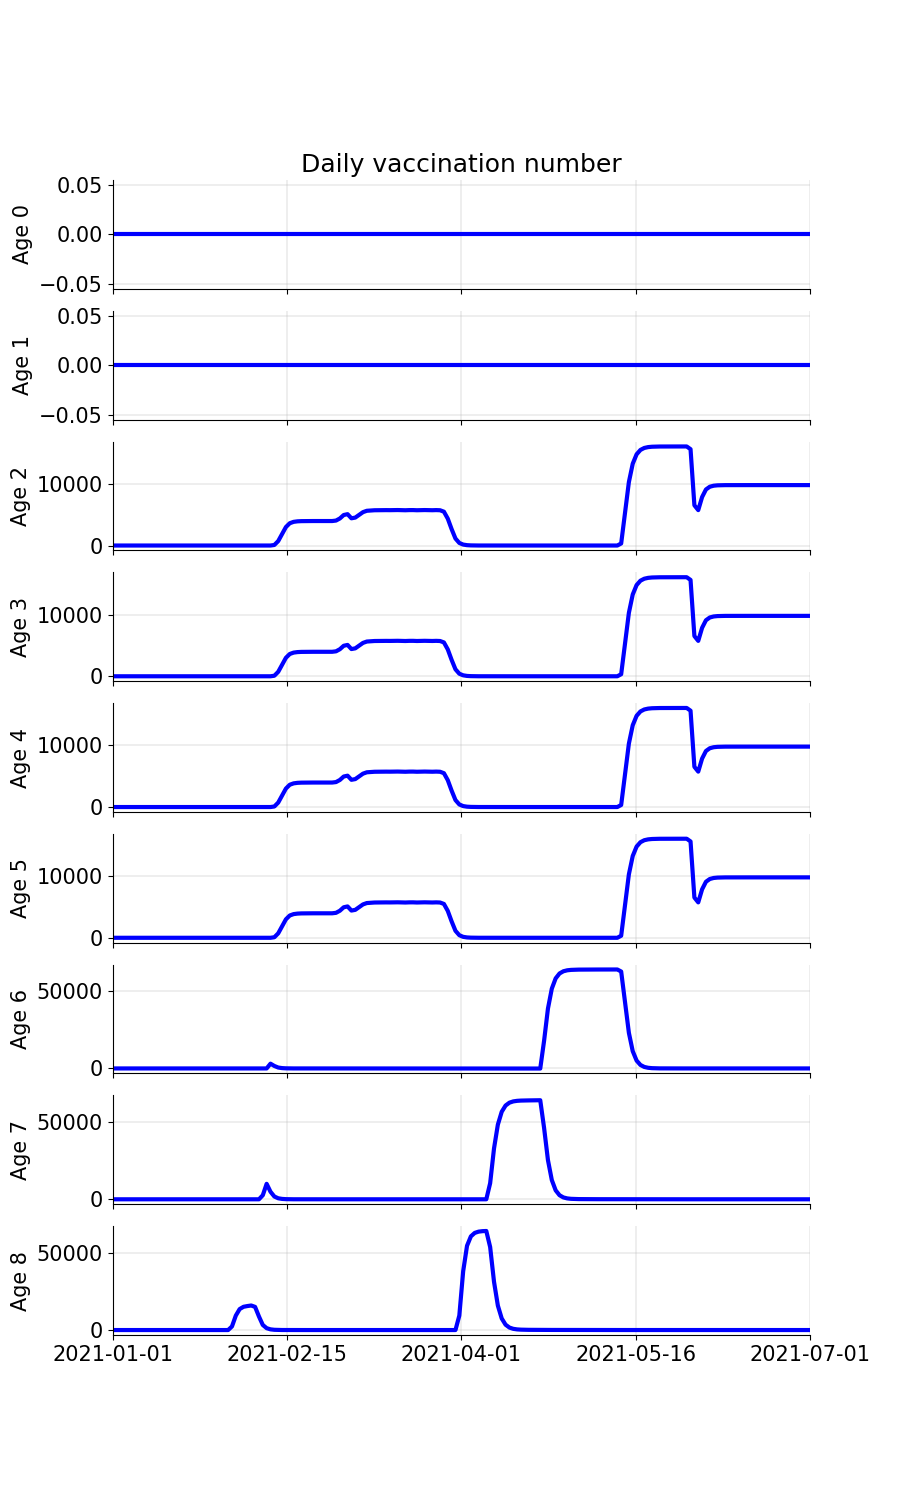

(737791.0, 737972.0)

In [258]:
fig,ax = plt.subplots(figsize=(9,15), nrows=9, sharex=True)
for i in range(9):
    #ax[i].plot('date', str(i), data=test_df, c='green', label='time-dep function', alpha=0.5)
    ax[i].plot(out_single['time'], out_single['V_new'].sel(Nc=i), c='blue', label='model')#, linestyle='--'
    ax[i].set_ylabel('Age '+str(i))
ax[0].set_title('Daily vaccination number')
#ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.9), ncol=2)
dates = pd.date_range(start_fig, end_sim, periods=5)
ax[0].set_xticks(dates)
ax[0].set_xlim(start_fig, end_sim)
#fig_path =  '../../results/predictions/national/restore_v7.0/'
#fig.savefig(fig_path+'Scenarios'+'.jpg', dpi=400, bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(figsize=(12,15), nrows=9, sharex=True)
for i in range(9):
    ax[i].plot(out_single['time'], out_single['VE'].sel(Nc=i), c='blue', label='model')
    #ax[i].legend()
    ax[i].set_ylabel('Age '+str(i))
ax[0].set_title('VE state')

In [ ]:
fig,ax = plt.subplots(figsize=(12,15), nrows=9, sharex=True)
for i in range(9):
    ax[i].plot(out_single['time'], out_single['VE'].sel(Nc=i), c='blue', label='model')
    #ax[i].legend()
    ax[i].set_ylabel('Age '+str(i))
ax[0].set_title('VE state')

# Test spatial model

N_vacc uit vaccination function moet hier 2D zijn! Geo unit x age class!

In [ ]:
geo_unit = 'prov'
initN_spatial, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012', spatial=geo_unit)
shape = initN_spatial.shape

In [ ]:
# divide daily vaccinations over spatial units according to population fraction in unit
fraction_per_arr = initN_spatial.sum(axis=1)/initN_spatial.sum().sum()
d_spatial = {key:el*fraction_per_arr[:,np.newaxis] for key,el in d.items()}

In [ ]:
# Need to initiate I also with the co-infection model, otherwise divison by zero occurs
initial_states = {'S': initN_spatial, 'E': np.ones(shape), 'I': np.ones(shape), 'alpha':np.zeros(shape)}

In [ ]:
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=geo_unit)
dummy_spatial_model = models.COVID19_SEIRD_spatial(initial_states, params, spatial=geo_unit)
sim_dummy_spatial_model = dummy_spatial_model.sim(time=end_sim, start_date=start_calibration)

In [ ]:
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=geo_unit)
params.update({'d' : d_spatial,
               'NH' : NH,
               'e' : np.ones(levels)*0.9,
               'order':None
              })
dummy_spatial_model_vacc = models.COVID19_SEIRD_spatial(initial_states, params, spatial=geo_unit, time_dependent_parameters={'N_vacc': vacc_strategy})
sim_dummy_spatial_model_vacc = dummy_spatial_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
%debug

In [ ]:
timerange = pd.date_range(start_calibration,'2021-09-01')
test_dict = {}
for t in timerange:
    test_dict[t] = np.sum(vacc_strategy(t=t, param=None, d=d, NH=NH, initN=initN_spatial), axis=1)
test_df = pd.DataFrame.from_dict(test_dict, orient='index').reset_index()
# test_df.columns = ['date','N_vacc']
# test_df['N_cum'] = test_df.N_vacc.cumsum()

In [ ]:
vacc_strategy(t=t, param=None, d=d, NH=NH, initN=initN_spatial).shape

In [ ]:
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=geo_unit)
params.update({
               'e' : np.ones(levels)*0.9,
               'N_vacc': np.ones(shape)*50,
              })
dummy_spatial_model_vacc = models.COVID19_SEIRD_spatial(initial_states, params, spatial=geo_unit)#, time_dependent_parameters={'N_vacc': vacc_strategy}
sim_dummy_spatial_model_vacc = dummy_spatial_model_vacc.sim(time=end_sim, start_date=start_calibration)

**double stratified parameters toevoegen?**

In [ ]:
sim_dummy_spatial_model_vacc['V'].sum(dim=['place','Nc'])

In [ ]:
sim_dummy_spatial_model_vacc['V_new'].sum(dim=['place','Nc']).values

In [ ]:
fig,ax = plt.subplots(figsize=(9,5))
#ax.plot('date', 'N_vacc', data=test_df, c='green', label='time-dep function')
ax.plot(sim_dummy_spatial_model_vacc['time'], sim_dummy_spatial_model_vacc['V_new'].sum(dim=['place','Nc']), c='blue', linestyle='--', label='model')
ax.legend()
ax.set_ylabel('Daily vaccination number')

In [ ]:
population_status(sim_dummy_spatial_model.mean(dim='place'))

In [ ]:
sim_dummy_spatial_model_vacc.mean(dim='place')

In [ ]:
population_status(sim_dummy_spatial_model_vacc.mean(dim='place'))

# Scenarios

In [211]:
start_sim = '2020-09-01'
end_sim = '2021-07-01'
warmup = 0
n_samples = 3#100
n_draws_per_sample = 100#1000
effectivity = 0.9

In [212]:
Re_1feb = 0.958*1.4
# current estimation of UK prevalence between 20 and 40% => take 30%
current_UK = 0.3
# 5-6 days incubation
incubation_period = 5
n_periods = 30/incubation_period

In [213]:
# How much on January 1? (30 days ago)
portion_new_strain_introduced = current_UK/(Re_1feb**n_periods) #0.001
injection_day = (pd.Timestamp('2021-01-01') - pd.Timestamp(start_sim))/pd.Timedelta('1D')

In [214]:
order=None# [6,5,4,3,2,2,2]
elder=None#[8,7,7]

## Run and save all scenarios

See python file

In [259]:
scenario_settings = pd.DataFrame({
    'Scenario_name':['S1a','S1b','S1c','S1d','S1e',
                     'S2a','S2b','S2c','S2d','S2e',
                     'S3a','S3b','S3c','S3d','S3e',
                     'S4a','S4b','S4c','S4d','S4e'],
    'opening':(5*['3']+5*['4']+5*['3']+5*['4']),
    'effectivity':20*[0.7],
    'K':20*[1.5],
    'order':2*[None,[5,4,3,2,2,2,2],[2,3,4,5,5,5,5],[3,4,2,5,5,5,5],[0,1,2,3,4,5,5]]+2*[None,[6,5,4,3,2,2,2],[2,3,4,5,6,6,6],[3,4,2,5,6,6,6],[0,1,2,3,4,5,6]],
    'elder': 10*[[8,7,6]]+10*[[8,7,7]],
    'vacc_fun':4*([vacc_strategy]+4*[vacc_strategy_priors])
})

In [260]:
scenario_settings

,Scenario_name,opening,effectivity,K,order,elder,vacc_fun
0,S1a,3,0.7,1.5,None,"[8, 7, 6]",<function vacc_strategy at 0x1235089d0>
1,S1b,3,0.7,1.5,"[5, 4, 3, 2, 2, 2, 2]","[8, 7, 6]",<function vacc_strategy_priors at 0x114098b80>
2,S1c,3,0.7,1.5,"[2, 3, 4, 5, 5, 5, 5]","[8, 7, 6]",<function vacc_strategy_priors at 0x114098b80>
3,S1d,3,0.7,1.5,"[3, 4, 2, 5, 5, 5, 5]","[8, 7, 6]",<function vacc_strategy_priors at 0x114098b80>
4,S1e,3,0.7,1.5,"[0, 1, 2, 3, 4, 5, 5]","[8, 7, 6]",<function vacc_strategy_priors at 0x114098b80>
5,S2a,4,0.7,1.5,None,"[8, 7, 6]",<function vacc_strategy at 0x1235089d0>
6,S2b,4,0.7,1.5,"[5, 4, 3, 2, 2, 2, 2]","[8, 7, 6]",<function vacc_strategy_priors at 0x114098b80>
7,S2c,4,0.7,1.5,"[2, 3, 4, 5, 5, 5, 5]","[8, 7, 6]",<function vacc_strategy_priors at 0x114098b80>
8,S2d,4,0.7,1.5,"[3, 4, 2, 5, 5, 5, 5]","[8, 7, 6]",<function vacc_strategy_priors at 0x114098b80>
9,S2e,4,0.7,1.5,"[0, 1, 2, 3, 4, 5, 5]","[8, 7, 6]",<function vacc_strategy_priors at 0x114098b80>


## Scenarios S1 (current behaviour)

In [215]:
scenario = '1'

### S1a - K = 1.3

In [216]:
K=1.3

In [219]:
model_S1a = vaccin_model(initial_states_sept, scenario=scenario, order=order, elder=elder, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
model_S1a.parameters.update({'K':K})
out_S1a = model_S1a.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [220]:
S1a_H_in_binom = sample_from_binomial(out_S1a, 'H_in', n_draws_per_sample, n_samples)
S1a_H_tot_binom = sample_from_binomial(out_S1a, 'H_tot', n_draws_per_sample, n_samples)
S1a_time = out_S1a["time"].values
S1a_alpha = out_S1a['alpha'].mean(dim="Nc").values

### S1b - K = 1.5

In [221]:
K=1.5

In [222]:
model_S1b = vaccin_model(initial_states_sept, scenario=scenario, order=order, elder=elder, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
model_S1b.parameters.update({'K':K})
out_S1b = model_S1b.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [223]:
S1b_H_in_binom = sample_from_binomial(out_S1b, 'H_in', n_draws_per_sample, n_samples)
S1b_H_tot_binom = sample_from_binomial(out_S1b, 'H_tot', n_draws_per_sample, n_samples)
S1b_time = out_S1b["time"].values
S1b_alpha = out_S1b['alpha'].mean(dim="Nc").values

### S1c - K = 1.7

In [224]:
K=1.7
infectivity_gain_lower=K
infectivity_gain_upper=K


In [225]:
model_S1c = vaccin_model(initial_states_sept, scenario=scenario, order=order, elder=elder, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
model_S1c.parameters.update({'K':K})
out_S1c = model_S1c.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [226]:
S1c_H_in_binom = sample_from_binomial(out_S1c, 'H_in', n_draws_per_sample, n_samples)
S1c_H_tot_binom = sample_from_binomial(out_S1c, 'H_tot', n_draws_per_sample, n_samples)
S1c_time = out_S1c["time"].values
S1c_alpha = out_S1c['alpha'].mean(dim="Nc").values

## Scenarios S2 (september behaviour March 1)

In [227]:
scenario = '2'

### S2a - K = 1.3

In [228]:
K=1.3
infectivity_gain_lower=K
infectivity_gain_upper=K

In [229]:
model_S2a = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
model_S2a.parameters.update({'K':K})
out_S2a = model_S2a.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [230]:
S2a_H_in_binom = sample_from_binomial(out_S2a, 'H_in', n_draws_per_sample, n_samples)
S2a_H_tot_binom = sample_from_binomial(out_S2a, 'H_tot', n_draws_per_sample, n_samples)
S2a_time = out_S2a["time"].values
S2a_alpha = out_S2a['alpha'].mean(dim="Nc").values


### S2b - K = 1.5

In [231]:
K=1.5
infectivity_gain_lower=K
infectivity_gain_upper=K

In [232]:
#%%snakeviz
model_S2b = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
model_S2b.parameters.update({'K':K})
out_S2b = model_S2b.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [233]:
S2b_H_in_binom = sample_from_binomial(out_S2b, 'H_in', n_draws_per_sample, n_samples)
S2b_H_tot_binom = sample_from_binomial(out_S2b, 'H_tot', n_draws_per_sample, n_samples)
S2b_time = out_S2b["time"].values
S2b_alpha = out_S2b['alpha'].mean(dim="Nc").values

## Scenarios SNV1 (vaccination effect)

### S3a (S2b without vaccination)

In [ ]:
scenario = '2'

In [ ]:
K=1.5
infectivity_gain_lower=K
infectivity_gain_upper=K

In [ ]:
model_S3a = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=None)
model_S3a.parameters.update({'K':K})

out_S3a = model_S3a.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [ ]:
S3a_H_in_binom = sample_from_binomial(out_S3a, 'H_in', n_draws_per_sample, n_samples)
S3a_H_tot_binom = sample_from_binomial(out_S3a, 'H_tot', n_draws_per_sample, n_samples)
S3a_time = out_S3a["time"].values
S3a_alpha = out_S3a['alpha'].mean(dim="Nc").values


### S4a (S1b without vaccination)

In [ ]:
scenario = '1'

In [ ]:
K=1.5
infectivity_gain_lower=K
infectivity_gain_upper=K

In [ ]:
model_S4a = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, 
                         injection_day=injection_day, injection_ratio=portion_new_strain_introduced,
                         Nc_fun=report7_policy_function, N_vacc_fun=None)
model_S4a.parameters.update({'K':K})

out_S4a = model_S4a.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)


In [ ]:
S4a_H_in_binom = sample_from_binomial(out_S4a, 'H_in', n_draws_per_sample, n_samples)
S4a_H_tot_binom = sample_from_binomial(out_S4a, 'H_tot', n_draws_per_sample, n_samples)
S4a_time = out_S4a["time"].values
S4a_alpha = out_S4a['alpha'].mean(dim="Nc").values


# Visualise

## S1 and S2

<IPython.core.display.Javascript object>


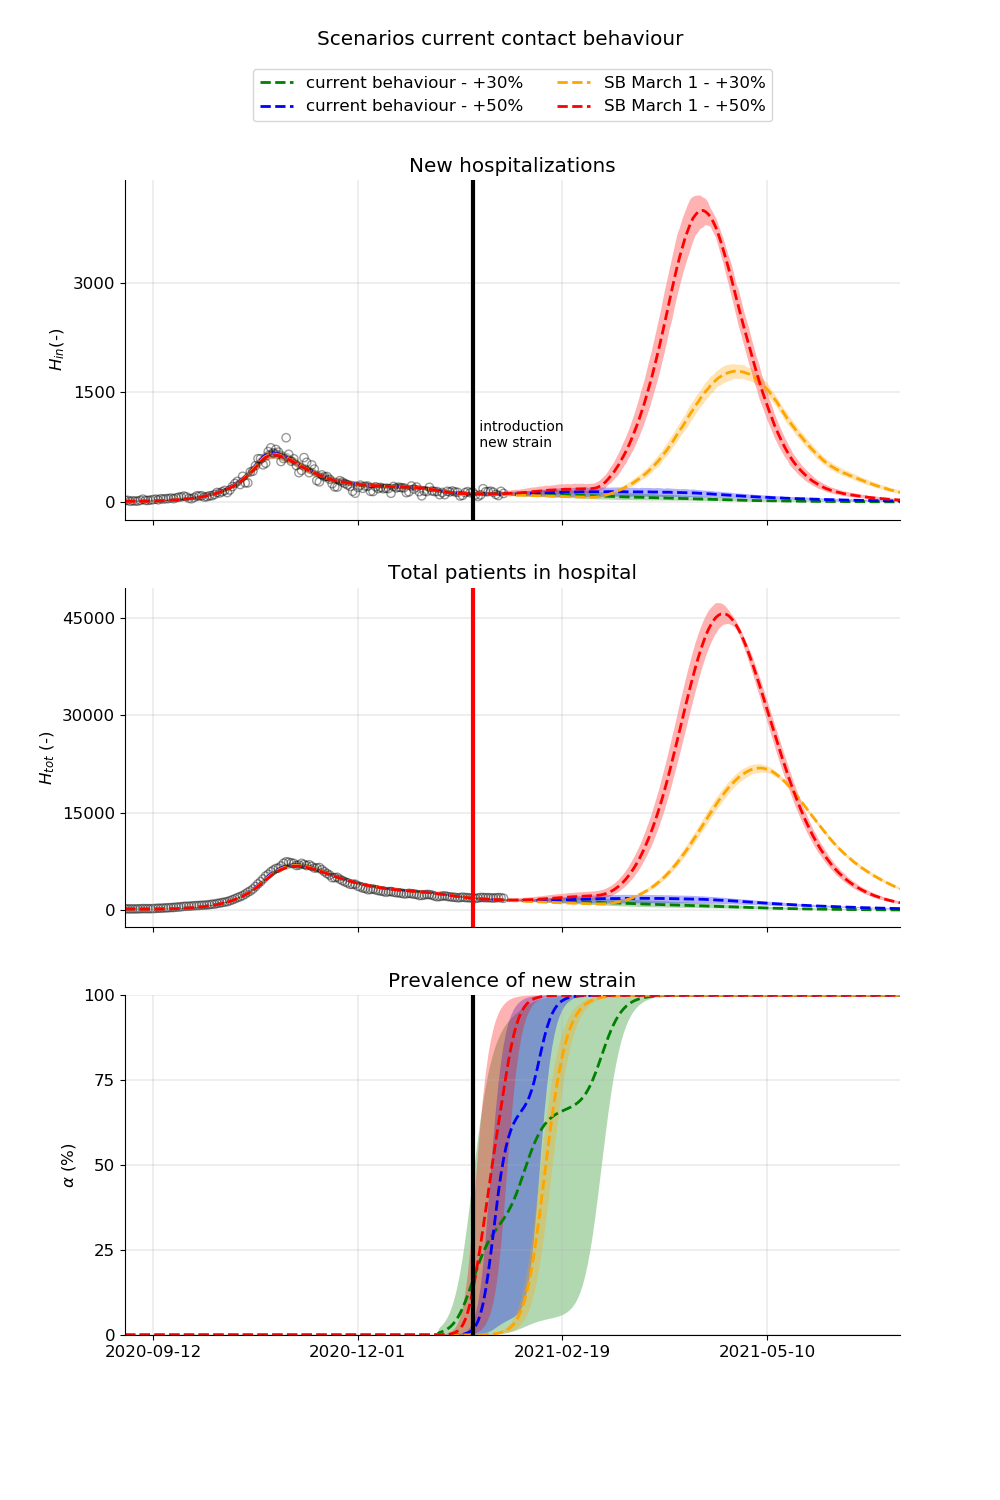

In [235]:
# ----------------
# Visualize result
# ----------------
# Plot
fig,(ax1, ax2, ax3) = plt.subplots(3,sharex=True,figsize=(10,15))
legend_pos = (0.5, 1.35)
legend_col = 2

label1 = 'current behaviour - +30%'
label2 = 'current behaviour - +50%'
label3 = 'SB March 1 - +30%'
label4 = 'SB March 1 - +50%'
label5 = 'SB May 1 - +50% '

# Incidence
plot_band_binom(ax1, S1a_time, S1a_H_in_binom, 'green', label=label1)
plot_band_binom(ax1, S1b_time, S1b_H_in_binom, 'blue', label=label2)
plot_band_binom(ax1, S2a_time, S2a_H_in_binom, 'orange', label=label3)
plot_band_binom(ax1, S2b_time, S2b_H_in_binom, 'red', label=label4)
#plot_band_binom(ax1, S5b_time, S5b_H_in_binom, 'lightblue', label=label5)

ax1.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax1.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=legend_col)

# Load
plot_band_binom(ax2, S1a_time, S1a_H_tot_binom, 'green', label=label1)
plot_band_binom(ax2, S1b_time, S1b_H_tot_binom, 'blue', label=label2)
plot_band_binom(ax2, S2a_time, S2a_H_tot_binom, 'orange', label=label3)
plot_band_binom(ax2, S2b_time, S2b_H_tot_binom, 'red', label=label4)
#plot_band_binom(ax2, S5b_time, S5b_H_tot_binom, 'lightblue', label=label5)


ax2.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_tot'][start_sim:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

# British variant
plot_band_binom(ax3, S1a_time, S1a_alpha*100, 'green', label=label1, axis=0)
plot_band_binom(ax3, S1b_time, S1b_alpha*100, 'blue', label=label2, axis=0)
plot_band_binom(ax3, S2a_time, S2a_alpha*100, 'orange', label=label3, axis=0)
plot_band_binom(ax3, S2b_time, S2b_alpha*100, 'red', label=label4, axis=0)
#plot_band_binom(ax3, S5b_time, S5b_alpha*100, 'lightblue', label=label5, axis=0)

# Format
ax1.set_title('New hospitalizations')
ax1.set_ylabel('$H_{in} $(-)')
ax1.set_xlim('2020-09-01',end_sim)
ax1.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax1.text(pd.Timestamp('2021-01-16'),750, ' introduction \n new strain', fontsize=10)
ax1 = _apply_tick_locator(ax1)
ax2.set_title('Total patients in hospital')
ax2.set_ylabel('$H_{tot}$ (-)')
ax2.set_xlim('2020-09-01',end_sim)
ax2.axvline(x=pd.to_datetime('2021-01-15'),color='red')
ax2 = _apply_tick_locator(ax2)
ax3.set_title('Prevalence of new strain')
ax3.set_ylabel('$\\alpha$ (%)')
ax3.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax3.set_xlim('2020-09-01',end_sim)
ax3.set_ylim(0,100)
ax3 = _apply_tick_locator(ax3)
# date_exceed = get_date_of_exceeding_alpha(out_S1a, ['Nc', 'draws'], 0.25)
# ax3.axvline(x=date_exceed, color='gray')
# ax3.text(date_exceed+pd.Timedelta('1D'),10, ' exceeding \n 25% on {}/{}'.format(date_exceed.day, date_exceed.month), 
#          fontsize=10, color='gray')


fig.suptitle('Scenarios current contact behaviour')

fig_path =  '../../results/predictions/national/restore_v7.0/'
#fig.savefig(fig_path+'Scenarios'+'.jpg', dpi=400, bbox_inches='tight')

In [ ]:
get_date_of_exceeding_alpha(out_S1b, ['Nc', 'draws'], 0.45)

In [ ]:
check_overtake_duration(out_S1a, ['Nc', 'draws'])

## Vaccination effect

In [ ]:
# ----------------
# Visualize result
# ----------------
# Plot
fig,(ax1, ax2, ax3) = plt.subplots(3,sharex=True,figsize=(10,15))
legend_pos = (0.5, 1.35)
legend_col = 2

label1 = 'current behaviour - +50% - no vaccination'
label2 = 'current behaviour - +50%'
label3 = 'september behaviour - +30 - no vaccination%'
label4 = 'september behaviour - +50%'

# Incidence
plot_band_binom(ax1, S4a_time, S4a_H_in_binom, 'green', label=label1)
plot_band_binom(ax1, S1b_time, S1b_H_in_binom, 'blue', label=label2)
plot_band_binom(ax1, S3a_time, S3a_H_in_binom, 'orange', label=label3)
plot_band_binom(ax1, S2b_time, S2b_H_in_binom, 'red', label=label4)

ax1.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax1.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=legend_col)

# Load
plot_band_binom(ax2, S4a_time, S4a_H_tot_binom, 'green', label=label1)
plot_band_binom(ax2, S1b_time, S1b_H_tot_binom, 'blue', label=label2)
plot_band_binom(ax2, S3a_time, S3a_H_tot_binom, 'orange', label=label3)
plot_band_binom(ax2, S2b_time, S2b_H_tot_binom, 'red', label=label4)

ax2.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_tot'][start_sim:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

# British variant
plot_band_binom(ax3, S4a_time, S4a_alpha*100, 'green', label=label1, axis=0)
plot_band_binom(ax3, S1b_time, S1b_alpha*100, 'blue', label=label2, axis=0)
plot_band_binom(ax3, S3a_time, S3a_alpha*100, 'orange', label=label3, axis=0)
plot_band_binom(ax3, S2b_time, S2b_alpha*100, 'red', label=label4, axis=0)

# Format
ax1.set_title('New hospitalizations')
ax1.set_ylabel('$H_{in} $(-)')
ax1.set_xlim('2020-09-01',end_sim)
ax1.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax1.text(pd.Timestamp('2021-01-16'),750, ' introduction \n new strain', fontsize=10)
ax1 = _apply_tick_locator(ax1)
ax2.set_title('Total patients in hospital')
ax2.set_ylabel('$H_{tot}$ (-)')
ax2.set_xlim('2020-09-01',end_sim)
ax2.axvline(x=pd.to_datetime('2021-01-15'),color='red')
ax2 = _apply_tick_locator(ax2)
ax3.set_title('Prevalence of new strain')
ax3.set_ylabel('$\\alpha$ (%)')
ax3.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax3.set_xlim('2020-09-01',end_sim)
ax3.set_ylim(0,100)
ax3 = _apply_tick_locator(ax3)
# date_exceed = get_date_of_exceeding_alpha(out_S4a, ['Nc', 'draws'], 0.25)
# ax3.axvline(x=date_exceed, color='gray')
# ax3.text(date_exceed+pd.Timedelta('1D'),10, ' exceeding \n 25% on {}/{}'.format(date_exceed.day, date_exceed.month), 
#          fontsize=10, color='gray')


fig.suptitle('Scenarios current contact behaviour')

fig_path =  '../../results/predictions/national/restore_v7.0/'
#fig.savefig(fig_path+'Scenarios_vaccination'+'.jpg', dpi=400, bbox_inches='tight')

# Alternative scenarios A1

In [ ]:
start_sim1 = '2020-09-01'
end_sim1 = '2021-01-15' # Initiate new strain on 15 Jan
end_sim2 = '2021-05-01'
warmup = 0
n_samples = 5
n_draws_per_sample = 50
effectivity = 0.9
portion_new_strain_introduced = 0.001
scenario = '1'

## A1a - vacc - old strain

In [ ]:
model_A1a = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A1a = model_A1a.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A1a_H_in_binom = sample_from_binomial(out_A1a, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A1a_time = out_A1a["time"].values
A1a_alpha = out_A1a['alpha'].mean(dim="Nc").values

## A1b - no vacc - new strain

In [ ]:
model_A1b = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A1b = model_A1b.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_A1b.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_A1b_part2 = vaccin_model(initial_states_2, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A1b_part2 = model_A1b_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A1b_H_in_binom = sample_from_binomial(out_A1b, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A1b_H_in_binom = sample_from_binomial(out_A1b_part2, 'H_in', n_draws_per_sample, n_samples, LL, UL, A1b_H_in_binom)

In [ ]:
# A1b_H_tot_binom = sample_from_binomial(out_A1b, 'H_tot', n_draws_per_sample, n_samples, LL, UL)
# A1b_H_tot_binom = sample_from_binomial(out_A1b_part2, 'H_tot', n_draws_per_sample, n_samples, LL, UL, A1b_H_tot_binom)

In [ ]:
A1b_time = out_A1b["time"].values
A1b_alpha = out_A1b['alpha'].mean(dim="Nc").values
A1b_time = np.append(A1b_time, out_A1b_part2['time'].values)
A1b_alpha = np.append(A1b_alpha,out_A1b_part2['alpha'].mean(dim="Nc").values,axis=1)

## A1c - vaccination - old strain

In [ ]:
model_A1c = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A1c = model_A1c.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A1c_H_in_binom = sample_from_binomial(out_A1c, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A1c_time = out_A1c["time"].values
A1c_alpha = out_A1c['alpha'].mean(dim="Nc").values

## A1d - vaccination - new strain

In [ ]:
model_A1d = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A1d = model_A1d.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_A1d.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_A1d_part2 = vaccin_model(initial_states_2, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A1d_part2 = model_A1d_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
model_A1d_part2.parameters['beta']

In [ ]:
A1d_H_in_binom = sample_from_binomial(out_A1d, 'H_in', n_draws_per_sample, n_samples)
A1d_H_in_binom = sample_from_binomial(out_A1d_part2, 'H_in', n_draws_per_sample, n_samples, A1d_H_in_binom)

In [ ]:
# A1d_H_tot_binom = sample_from_binomial(out_A1d, 'H_tot', n_draws_per_sample, n_samples)
# A1d_H_tot_binom = sample_from_binomial(out_A1d_part2, 'H_tot', n_draws_per_sample, n_samples, A1d_H_tot_binom)

In [ ]:
A1d_time = out_A1d["time"].values
A1d_alpha = out_A1d['alpha'].mean(dim="Nc").values
A1d_time = np.append(A1d_time, out_A1d_part2['time'].values)
A1d_alpha = np.append(A1d_alpha,out_A1d_part2['alpha'].mean(dim="Nc").values,axis=1)

## Visualise

In [ ]:
# ----------------
# Visualize result
# ----------------
# Plot
fig,(ax1, ax3) = plt.subplots(2,sharex=True,figsize=(10,10))
legend_pos = (0.5, 1.25)
legend_col = 2

# Incidence
plot_band_binom(ax1, A1a_time, A1a_H_in_binom, 'green', label='no new strain')
plot_band_binom(ax1, A1b_time, A1b_H_in_binom, 'blue', label='new strain on 15/1')
plot_band_binom(ax1, A1c_time, A1c_H_in_binom, 'orange', label='no new strain - vacc')
plot_band_binom(ax1, A1d_time, A1d_H_in_binom, 'red', label='new strain on 15/1 - vacc')

ax1.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_in'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax1.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=legend_col)

# Load
# plot_band_binom(ax2, A1b_time, A1b_H_tot_binom, 'blue', label='H_in')
# ax2.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_tot'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')

# British variant
# ax3.plot(A1a_time,np.mean(A1a_alpha,axis=0)*100,'--', color='green', label='no new strain')
# ax3.plot(A1b_time,np.mean(A1b_alpha,axis=0)*100,'--', color='blue', label='new strain on 15/1')
# ax3.fill_between(A1b_time,np.quantile(A1b_alpha,UL,axis=0)*100, np.quantile(A1b_alpha,LL,axis=0)*100,alpha=0.20, color = 'blue')
plot_band_binom(ax3, A1a_time, A1a_alpha*100, 'green', label='no new strain', axis=0)
plot_band_binom(ax3, A1b_time, A1b_alpha*100, 'blue', label='new strain on 15/1', axis=0)
plot_band_binom(ax3, A1c_time, A1c_alpha*100, 'orange', label='no new strain - vacc', axis=0)
plot_band_binom(ax3, A1d_time, A1d_alpha*100, 'red', label='new strain on 15/1 - vacc', axis=0)

# Format
ax1.set_title('New hospitalizations')
ax1.set_ylabel('$H_{in} $(-)')
ax1.set_xlim('2020-09-01',end_sim2)
ax1.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax1.text(pd.Timestamp('2021-01-16'),750, ' introduction \n new strain', fontsize=10)
ax1 = _apply_tick_locator(ax1)
# ax2.set_title('Total patients in hospital')
# ax2.set_ylabel('$H_{tot}$ (-)')
# ax2.set_xlim('2020-09-01',end_sim2)
# ax2.axvline(x=pd.to_datetime('2021-01-15'),color='red')
# ax2 = _apply_tick_locator(ax2)
ax3.set_title('Prevalence of new strain')
ax3.set_ylabel('$\\alpha$ (%)')
ax3.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax3.set_xlim('2020-09-01',end_sim2)
ax3.set_ylim(0,100)
ax3 = _apply_tick_locator(ax3)
date_exceed = get_date_of_exceeding_alpha(out_A1b_part2, ['Nc', 'draws'], 0.25)
ax3.axvline(x=date_exceed, color='gray')
ax3.text(date_exceed+pd.Timedelta('1D'),10, ' exceeding \n 25% on {}/{}'.format(date_exceed.day, date_exceed.month), 
         fontsize=10, color='gray')


fig.suptitle('Scenarios current contact behaviour')

fig_path =  '../../results/predictions/national/restore_v7.0/'
#fig.savefig(fig_path+'restore_v7.0_'+'British_variant'+'.pdf', dpi=400, bbox_inches='tight')
fig.savefig(fig_path+'A1'+'.jpg', dpi=400, bbox_inches='tight')

In [ ]:
date_exceed = get_date_of_exceeding_alpha(out_A1b_part2, ['Nc', 'draws'], 0.25)

In [ ]:
check_overtake_duration(out_A1b_part2, ['Nc', 'draws'])

# Alternative scenarios A2

In [ ]:
start_sim1 = '2020-09-01'
end_sim1 = '2021-01-15' # Initiate new strain on 15 Jan
end_sim2 = '2021-07-01'
warmup = 0
n_samples = 5
n_draws_per_sample = 50
effectivity = 0.9
portion_new_strain_introduced = 0.001
scenario = '2a'

## A2a - no vacc - old strain

In [ ]:
model_A2a = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A2a = model_A2a.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A2a_H_in_binom = sample_from_binomial(out_A2a, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A2a_time = out_A2a["time"].values
A2a_alpha = out_A2a['alpha'].mean(dim="Nc").values

## A2b - no vacc - new strain

In [ ]:
model_A2b = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A2b = model_A2b.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_A2b.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_A2b_part2 = vaccin_model(initial_states_2, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_A2b_part2 = model_A2b_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A2b_H_in_binom = sample_from_binomial(out_A2b, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A2b_H_in_binom = sample_from_binomial(out_A2b_part2, 'H_in', n_draws_per_sample, n_samples, LL, UL, A2b_H_in_binom)

In [ ]:
# A2b_H_tot_binom = sample_from_binomial(out_A2b, 'H_tot', n_draws_per_sample, n_samples, LL, UL)
# A2b_H_tot_binom = sample_from_binomial(out_A2b_part2, 'H_tot', n_draws_per_sample, n_samples, LL, UL, A2b_H_tot_binom)

In [ ]:
A2b_time = out_A2b["time"].values
A2b_alpha = out_A2b['alpha'].mean(dim="Nc").values
A2b_time = np.append(A2b_time, out_A2b_part2['time'].values)
A2b_alpha = np.append(A2b_alpha,out_A2b_part2['alpha'].mean(dim="Nc").values,axis=1)

## A2c - vaccination - old strain

In [ ]:
model_A2c = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A2c = model_A2c.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A2c_H_in_binom = sample_from_binomial(out_A2c, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A2c_time = out_A2c["time"].values
A2c_alpha = out_A2c['alpha'].mean(dim="Nc").values

## A2d - vaccination - new strain

In [ ]:
model_A2d = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A2d = model_A2d.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_A2d.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_A2d_part2 = vaccin_model(initial_states_2, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_A2d_part2 = model_A2d_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [ ]:
A2d_H_in_binom = sample_from_binomial(out_A2d, 'H_in', n_draws_per_sample, n_samples, LL, UL)
A2d_H_in_binom = sample_from_binomial(out_A2d_part2, 'H_in', n_draws_per_sample, n_samples, LL, UL, A2d_H_in_binom)

In [ ]:
# A2d_H_tot_binom = sample_from_binomial(out_A2d, 'H_tot', n_draws_per_sample, n_samples, LL, UL)
# A2d_H_tot_binom = sample_from_binomial(out_A2d_part2, 'H_tot', n_draws_per_sample, n_samples, LL, UL, A2d_H_tot_binom)

In [ ]:
A2d_time = out_A2d["time"].values
A2d_alpha = out_A2d['alpha'].mean(dim="Nc").values
A2d_time = np.append(A2d_time, out_A2d_part2['time'].values)
A2d_alpha = np.append(A2d_alpha,out_A2d_part2['alpha'].mean(dim="Nc").values,axis=1)

## Visualise

In [ ]:
# ----------------
# Visualize result
# ----------------
# Plot
fig,(ax1, ax3) = plt.subplots(2,sharex=True,figsize=(10,10))
legend_pos = (0.5, 1.25)
legend_col = 2

# Incidence
plot_band_binom(ax1, A2a_time, A2a_H_in_binom, 'green', label='no new strain')
plot_band_binom(ax1, A2b_time, A2b_H_in_binom, 'blue', label='new strain on 15/1')
plot_band_binom(ax1, A2c_time, A2c_H_in_binom, 'orange', label='no new strain - vacc')
plot_band_binom(ax1, A2d_time, A2d_H_in_binom, 'red', label='new strain on 15/1 - vacc')

ax1.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_in'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax1.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=legend_col)

# Load
# plot_band_binom(ax2, A2b_time, A2b_H_tot_binom, 'blue', label='H_in')
# ax2.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_tot'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')

# British variant
# ax3.plot(A2a_time,np.mean(A2a_alpha,axis=0)*100,'--', color='green', label='no new strain')
# ax3.plot(A2b_time,np.mean(A2b_alpha,axis=0)*100,'--', color='blue', label='new strain on 15/1')
# ax3.fill_between(A2b_time,np.quantile(A2b_alpha,UL,axis=0)*100, np.quantile(A2b_alpha,LL,axis=0)*100,alpha=0.20, color = 'blue')
plot_band_binom(ax3, A2a_time, A2a_alpha*100, 'green', label='no new strain', axis=0)
plot_band_binom(ax3, A2b_time, A2b_alpha*100, 'blue', label='new strain on 15/1', axis=0)
plot_band_binom(ax3, A2c_time, A2c_alpha*100, 'orange', label='no new strain - vacc', axis=0)
plot_band_binom(ax3, A2d_time, A2d_alpha*100, 'red', label='new strain on 15/1 - vacc', axis=0)

# Format
ax1.set_title('New hospitalizations')
ax1.set_ylabel('$H_{in} $(-)')
ax1.set_xlim('2020-09-01',end_sim2)
ax1.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax1.text(pd.Timestamp('2021-01-16'),750, ' introduction \n new strain', fontsize=10)
ax1 = _apply_tick_locator(ax1)
# ax2.set_title('Total patients in hospital')
# ax2.set_ylabel('$H_{tot}$ (-)')
# ax2.set_xlim('2020-09-01',end_sim2)
# ax2.axvline(x=pd.to_datetime('2021-01-15'),color='red')
# ax2 = _apply_tick_locator(ax2)
ax3.set_title('Prevalence of new strain')
ax3.set_ylabel('$\\alpha$ (%)')
ax3.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax3.set_xlim('2020-09-01',end_sim2)
ax3.set_ylim(0,100)
ax3 = _apply_tick_locator(ax3)
date_exceed = get_date_of_exceeding_alpha(out_A2b_part2, ['Nc', 'draws'], 0.25)
ax3.axvline(x=date_exceed, color='gray')
ax3.text(date_exceed+pd.Timedelta('1D'),10, ' exceeding \n 25% on {}/{}'.format(date_exceed.day, date_exceed.month), 
         fontsize=10, color='gray')


fig.suptitle('Scenarios release on  March 1')

fig_path =  '../../results/predictions/national/restore_v7.0/'
#fig.savefig(fig_path+'restore_v7.0_'+'British_variant'+'.pdf', dpi=400, bbox_inches='tight')
fig.savefig(fig_path+'A2'+'.jpg', dpi=400, bbox_inches='tight')

# Save data

In [ ]:
results = pd.DataFrame()
results['Date'] =  out_S1a['time']
for x in ['S1a', 'S1b', 'S2a', 'S2b', 'S3a', 'S4a', 'S5a', 'S5b']:
    for var in ['H_in', 'H_tot']:
        binom = eval(x+'_'+var+'_binom')
        if var == 'H_in':
            results[x+'_incidences_mean'] = np.mean(binom, axis=1)
            results[x+'_incidences_median'] = np.median(binom, axis=1)
            results[x+'_incidences_LL'] = np.quantile(binom, q = LL, axis = 1)
            results[x+'_incidences_UL'] = np.quantile(binom, q = UL, axis = 1)
        if var == 'H_tot':
            results[x+'_load_mean'] = np.mean(binom, axis=1)
            results[x+'_load_median'] = np.median(binom, axis=1)
            results[x+'_load_LL'] = np.quantile(binom, q = LL, axis = 1)
            results[x+'_load_UL'] = np.quantile(binom, q = UL, axis = 1)
            
results.to_csv('../../results/predictions/national/restore_v7.0/UGent_restore_v7.csv')

# Plot saved data

In [ ]:
S_results_H_in = pd.read_csv('../../results/vaccinations/national/S_results_H_in.csv', parse_dates=['time'])

In [ ]:
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')


In [ ]:
fig,(ax3,ax4) = plt.subplots(figsize=(10,5), nrows=1, ncols=2, sharex=True, sharey=True)

ax3.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')

# plot_band(ax3, y_model_S4a, 'H_in', 'C0', '0% at start')
# plot_band(ax3, y_model_S4b, 'H_in', 'C1', '10% at start')
# plot_band(ax3, y_model_S4c, 'H_in', 'C2', '30% at start')
# plot_band(ax3, y_model_S4d, 'H_in', 'C3', '50% at start')

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('Vaccination according to age')

ax4.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
# plot_band(ax4, y_model_S1, 'H_in', 'gray', 'no vaccination')
# plot_band(ax4, y_model_S5a, 'H_in', 'C0', '0% at start')
# plot_band(ax4, y_model_S5b, 'H_in', 'C1', '10% at start')
# plot_band(ax4, y_model_S5c, 'H_in', 'C2', '30% at start')
# plot_band(ax4, y_model_S5d, 'H_in', 'C3', '50% at start')

ax4.set_xlim(start_x, end_x)
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('Vaccination according to number of contacts')


ax3.legend(loc='upper center', bbox_to_anchor=(1, 1.35), ncol=3)
ax3.set_ylim(0,800)
fig.text(0, 0.5, 'Number of new hospitalizations', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')
